# Plant Leaf Disease Detection

## ADS - 599 Capstone Project
### Team 2

*   Kaustav Ghosh Dastiar
*   Muris Saab
*   Nishok Narayanan





In [65]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


from keras.preprocessing import image
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import Sequential
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# Set default plot style
plt.style.use('ggplot')


In [68]:
# Define the dataset paths (update as necessary)
train_dir = '/Users/kaustavghoshdastidar/Documents/My_World/My_Study_Program/Masters/Research_Paper-Assignments/ADS-599_Final_Capstone_Project/plant_leaf_diesease_detection/dataset/train' #'/kaggle/input/leaf-disease-detection-dataset/dataset/train'
test_dir = '/Users/kaustavghoshdastidar/Documents/My_World/My_Study_Program/Masters/Research_Paper-Assignments/ADS-599_Final_Capstone_Project/plant_leaf_diesease_detection/dataset/test' #'/kaggle/input/leaf-disease-detection-dataset/dataset/test'


# Function to load data from directories and create DataFrames
def load_data(directory):
    filepaths, labels = [], []
    class_list = sorted(os.listdir(directory))
    for klass in class_list:
        classpath = os.path.join(directory, klass)

        # Skip files that are not directories
        if not os.path.isdir(classpath):
            continue
        
        parts = klass.split('__')
        label = parts[1] if len(parts) > 1 else 'Unknown'
        
        file_list = os.listdir(classpath)
        for file in file_list:
            filepaths.append(os.path.join(classpath, file))
            labels.append(label)

    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Load training and testing datasets
train_df = load_data(train_dir) if os.path.exists(train_dir) else pd.DataFrame()
test_df = load_data(test_dir) if os.path.exists(test_dir) else pd.DataFrame()

# Display basic info about the datasets
print(f"Training Data: {train_df.shape[0]} samples, {train_df['labels'].nunique()} classes")
print(f"Testing Data: {test_df.shape[0]} samples, {test_df['labels'].nunique()} classes")

Training Data: 70295 samples, 21 classes
Testing Data: 17572 samples, 21 classes


In [18]:
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

The number of classes in the dataset is:  21
            CLASS               IMAGE COUNT 
         _Apple_scab               2016     
       _Bacterial_spot             5453     
          _Black_rot               3875     
      _Cedar_apple_rust            1760     
_Cercospora_leaf_spot Gray_leaf_spot     1642     
        _Common_rust_              1907     
        _Early_blight              3859     
    _Esca_(Black_Measles)          1920     
_Haunglongbing_(Citrus_greening)     2010     
         _Late_blight              3790     
          _Leaf_Mold               1882     
_Leaf_blight_(Isariopsis_Leaf_Spot)     1722     
         _Leaf_scorch              1774     
    _Northern_Leaf_Blight          1908     
       _Powdery_mildew             3419     
     _Septoria_leaf_spot           1745     
_Spider_mites Two-spotted_spider_mite     1741     
         _Target_Spot              1827     
_Tomato_Yellow_Leaf_Curl_Virus     1961     
     _Tomato_mosaic_virus          

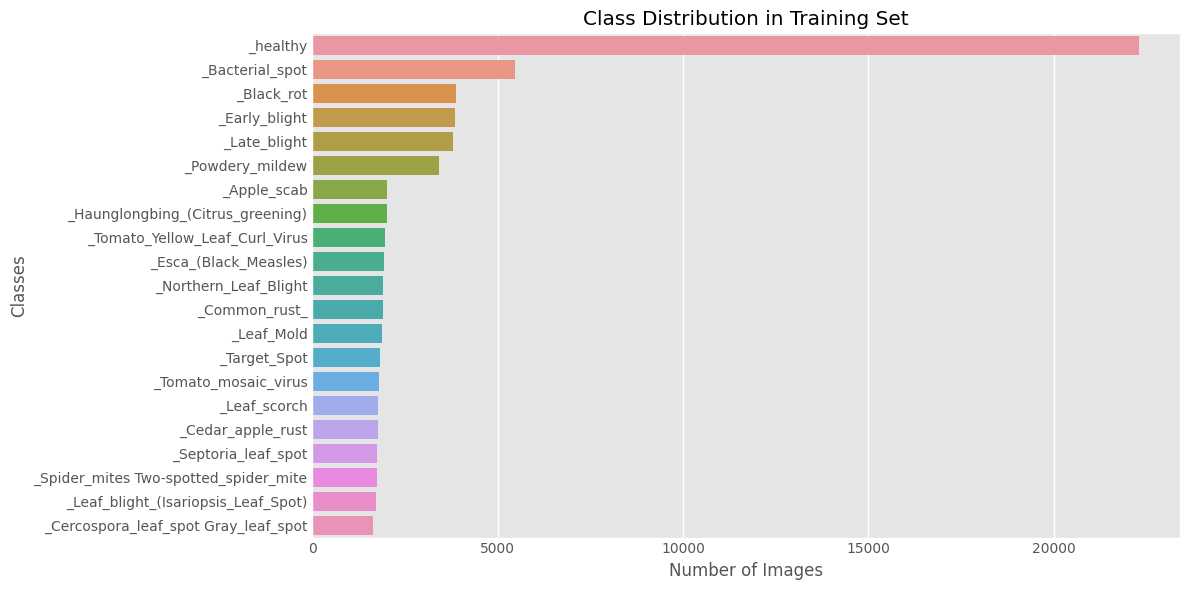

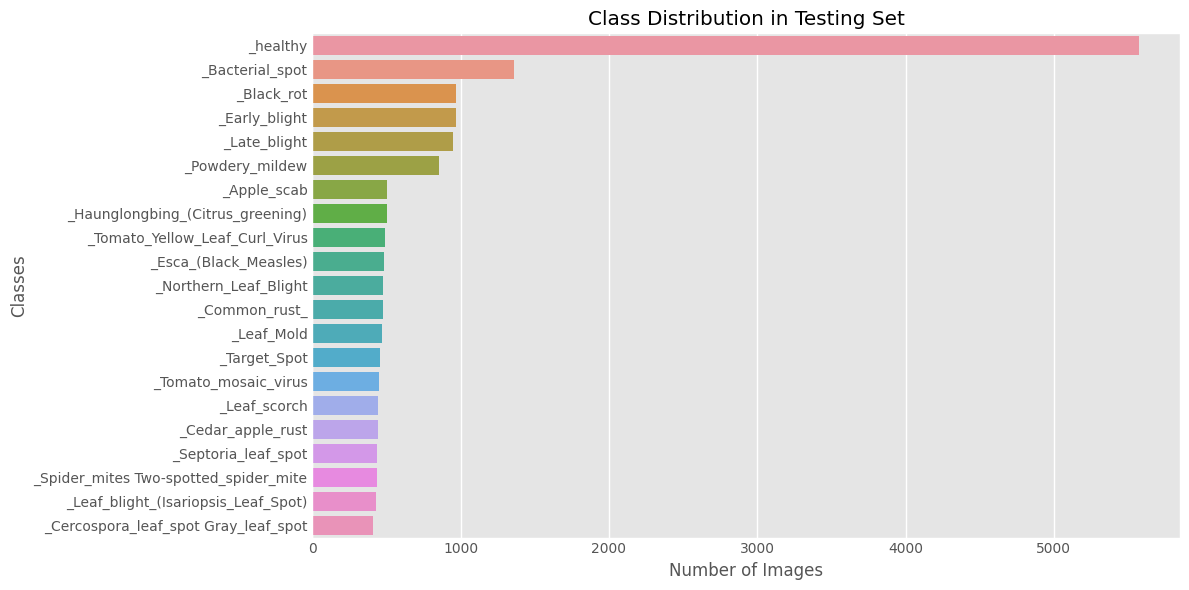

In [69]:

# Visualize class distribution in training set
if not train_df.empty:
    plt.figure(figsize=(12, 6))
    sns.countplot(y=train_df['labels'], order=train_df['labels'].value_counts().index)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Number of Images')
    plt.ylabel('Classes')
    plt.tight_layout()
    plt.show()

# Visualize class distribution in testing set
if not test_df.empty:
    plt.figure(figsize=(12, 6))
    sns.countplot(y=test_df['labels'], order=test_df['labels'].value_counts().index)
    plt.title('Class Distribution in Testing Set')
    plt.xlabel('Number of Images')
    plt.ylabel('Classes')
    plt.tight_layout()
    plt.show()


In [71]:
train_gen = ImageDataGenerator(rescale=None,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_gen = ImageDataGenerator(rescale=None,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

training_set=train_gen.flow_from_directory(train_dir,
                                               target_size=(128,128),
                                               batch_size=32,
                                               class_mode='categorical')

test_set=test_gen.flow_from_directory(test_dir,
                                               target_size=(128,128),
                                               batch_size=32,
                                               class_mode='categorical')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


Images for Training......................


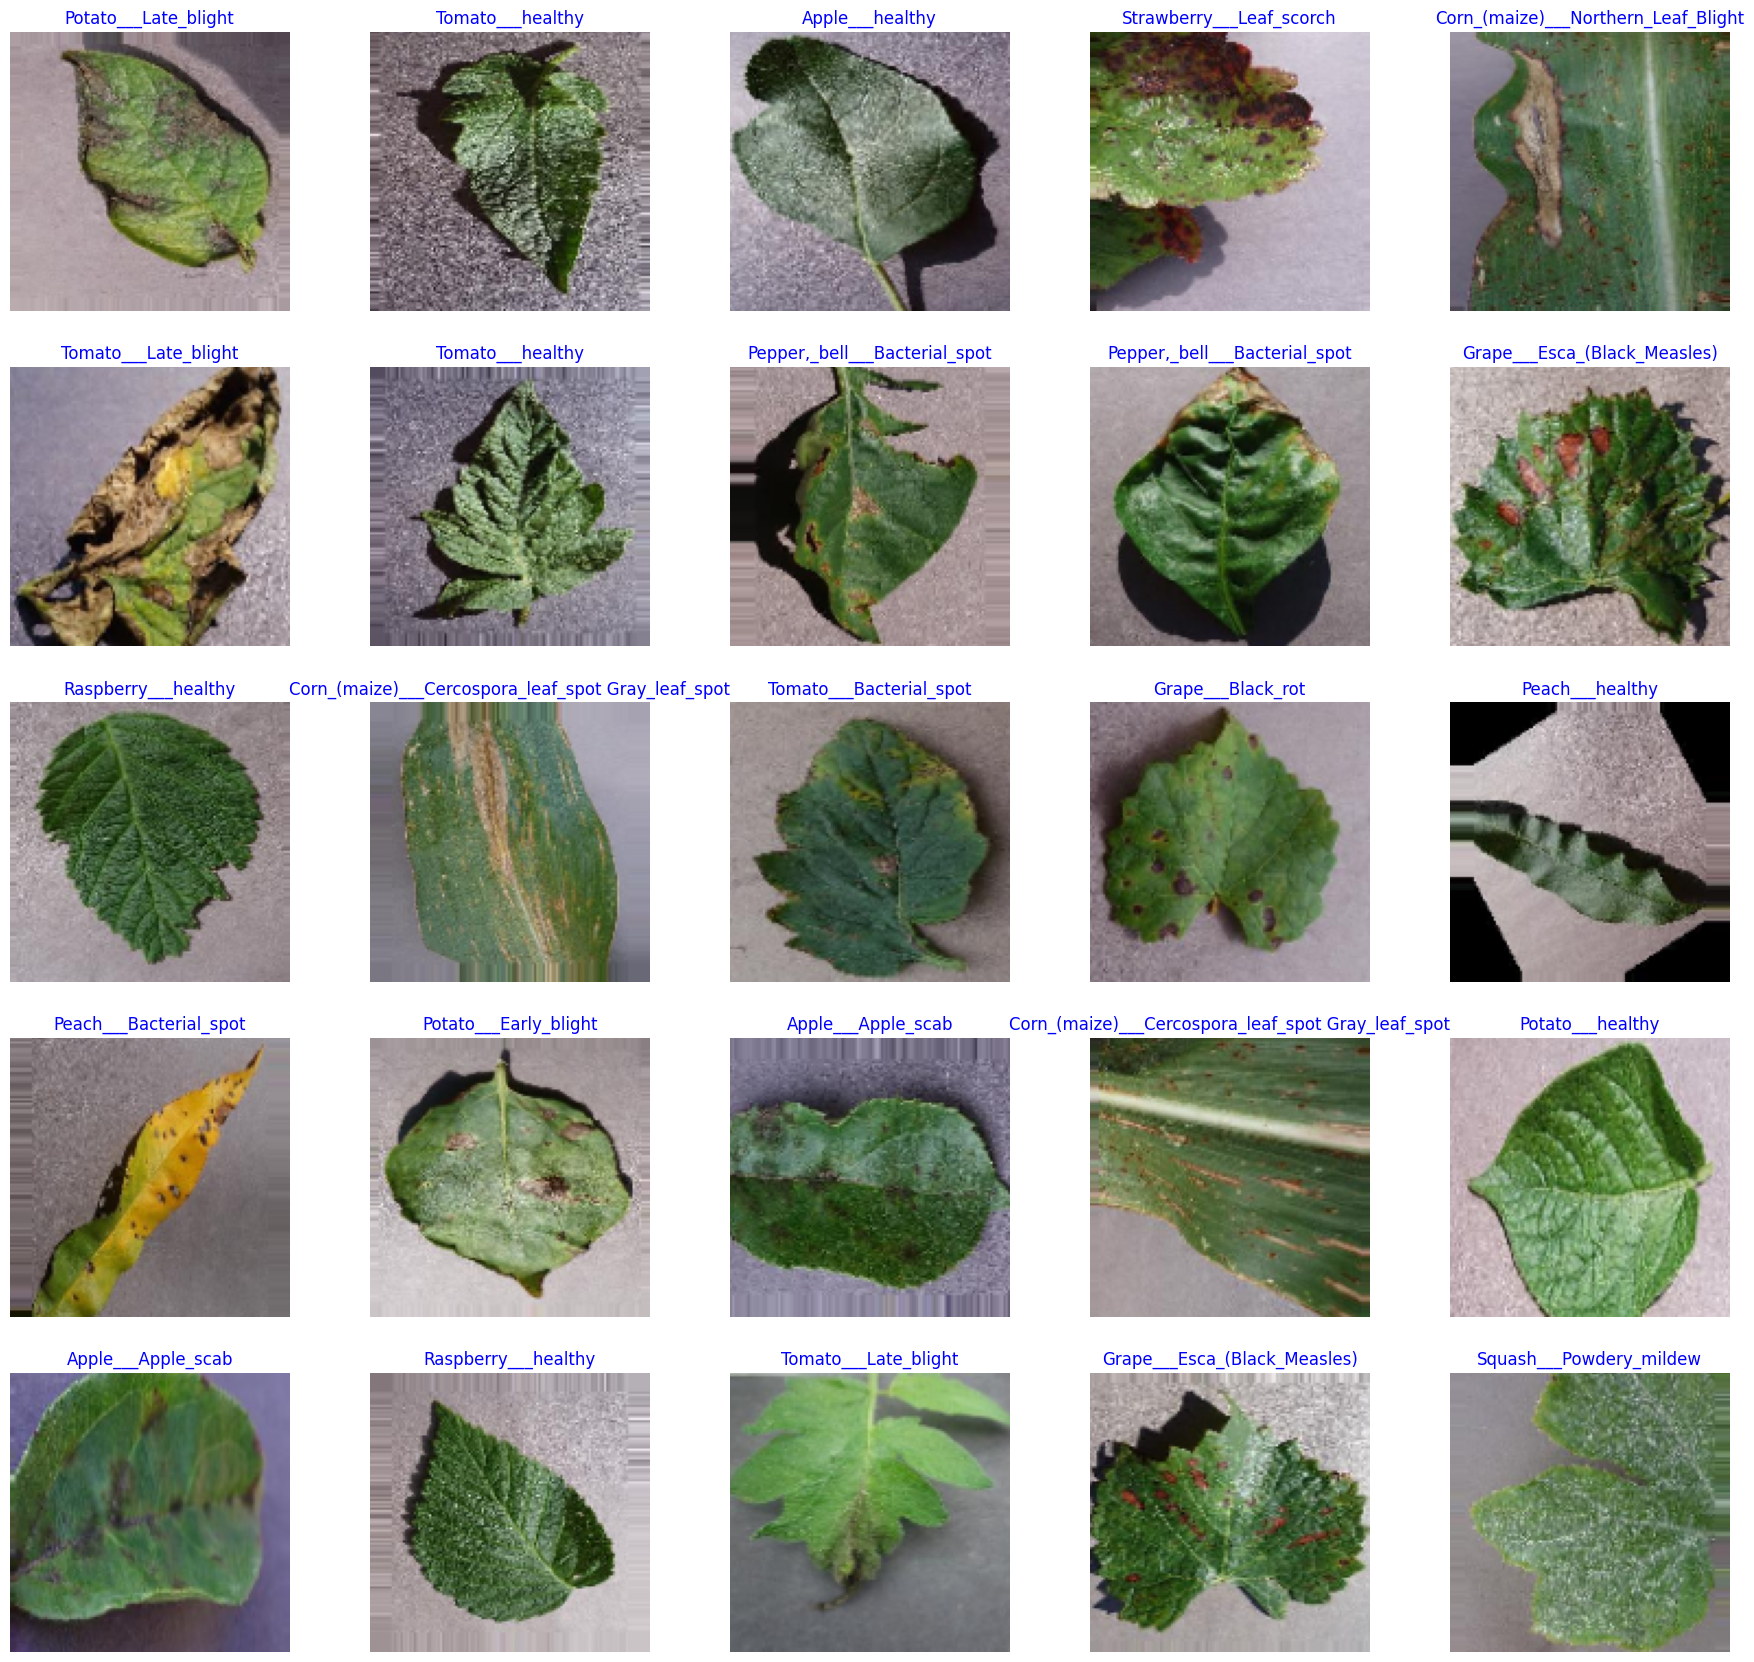

Images for Testing.......................


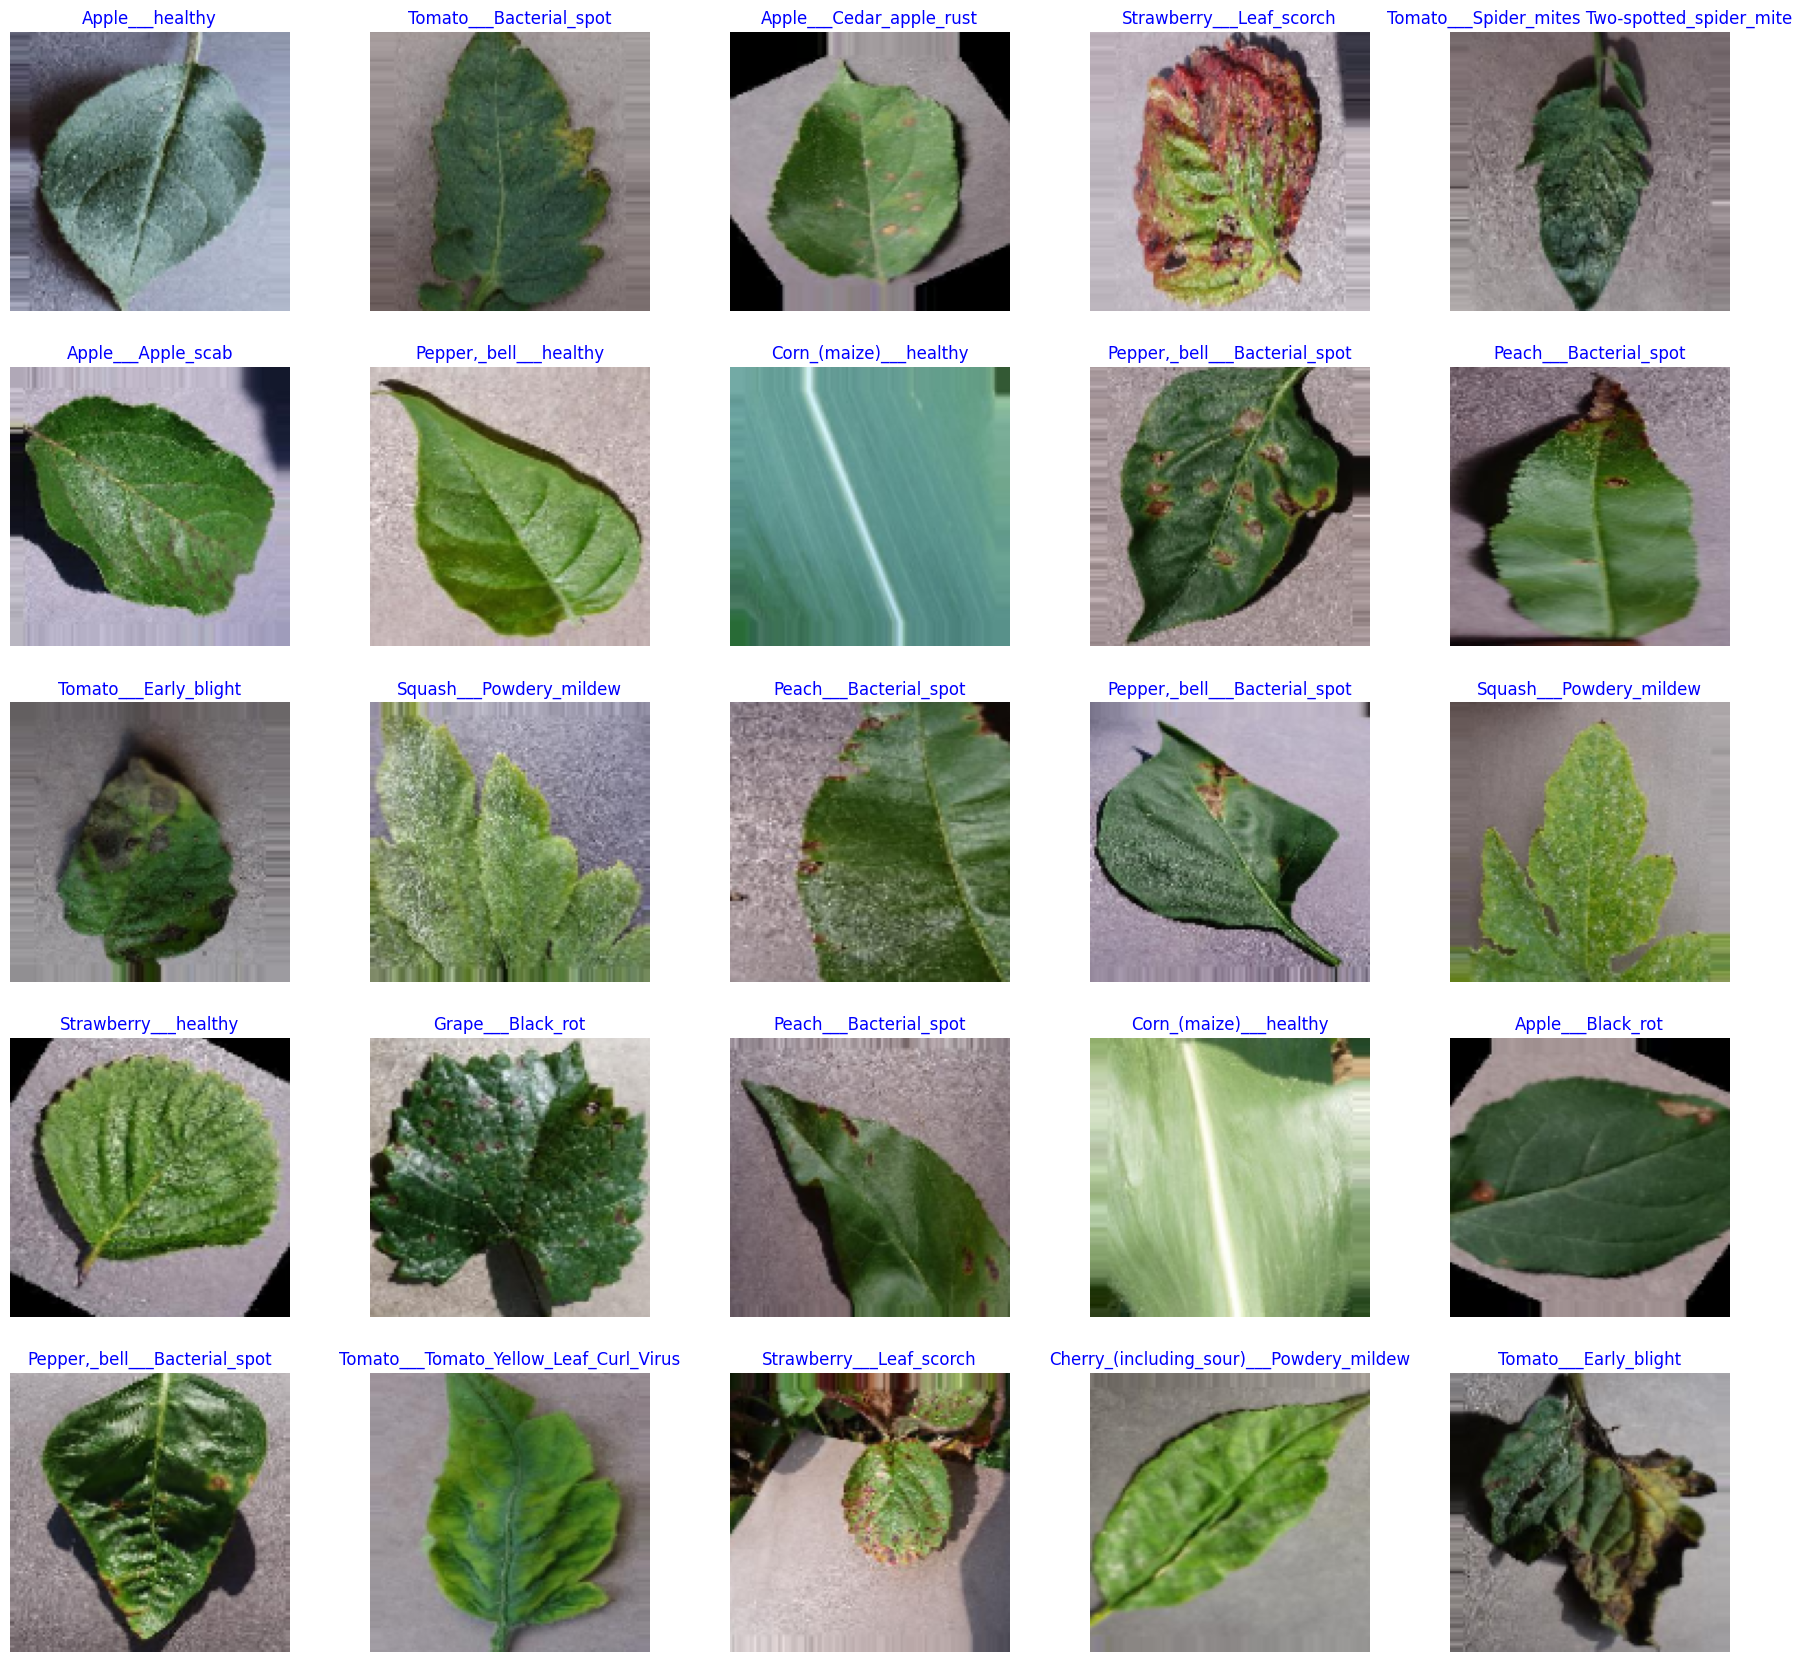

In [72]:
def show_image_samples(gen):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
print("Images for Training......................")
show_image_samples(training_set )
print("Images for Testing.......................")
show_image_samples(test_set )

## MODELS

### Convolutional Neural Network (CNN)

In [73]:
#basic cnn layers
model = Sequential()
model.add(Conv2D(32, kernel_size= (3,3), activation = 'relu',input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size =(2,2,)))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size= (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size =(2,2,)))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size= (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size =(2,2,)))
model.add(BatchNormalization())
model.add(Conv2D(96,kernel_size= (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size =(2,2,)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size= (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size =(2,2,)))
model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(38, activation = 'softmax'))
#compiling our model 
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

### MODEL Trainining

In [74]:
labels=(training_set.class_indices)
labels2=(test_set.class_indices)
#fitting data into our model
fitted_model = model.fit(training_set,
                    steps_per_epoch=375,
                    epochs=10,
                    validation_data = test_set,
                    validation_steps = 125)

Epoch 1/10
375/375 [==============================] - 89s 234ms/step - loss: 2.5814 - accuracy: 0.2869 - val_loss: 2.5051 - val_accuracy: 0.3045
Epoch 2/10
375/375 [==============================] - 83s 221ms/step - loss: 1.6411 - accuracy: 0.5023 - val_loss: 1.6794 - val_accuracy: 0.5010
Epoch 3/10
375/375 [==============================] - 84s 223ms/step - loss: 1.2917 - accuracy: 0.6017 - val_loss: 0.9383 - val_accuracy: 0.7035
Epoch 4/10
375/375 [==============================] - 72s 191ms/step - loss: 1.0559 - accuracy: 0.6717 - val_loss: 0.9073 - val_accuracy: 0.7117
Epoch 5/10
375/375 [==============================] - 74s 197ms/step - loss: 0.9498 - accuracy: 0.6999 - val_loss: 1.0224 - val_accuracy: 0.6815
Epoch 6/10
375/375 [==============================] - 77s 206ms/step - loss: 0.8094 - accuracy: 0.7440 - val_loss: 0.9190 - val_accuracy: 0.7095
Epoch 7/10
375/375 [==============================] - 77s 207ms/step - loss: 0.7435 - accuracy: 0.7672 - val_loss: 0.7690 - val_ac

### Plotting Training and Validation Data

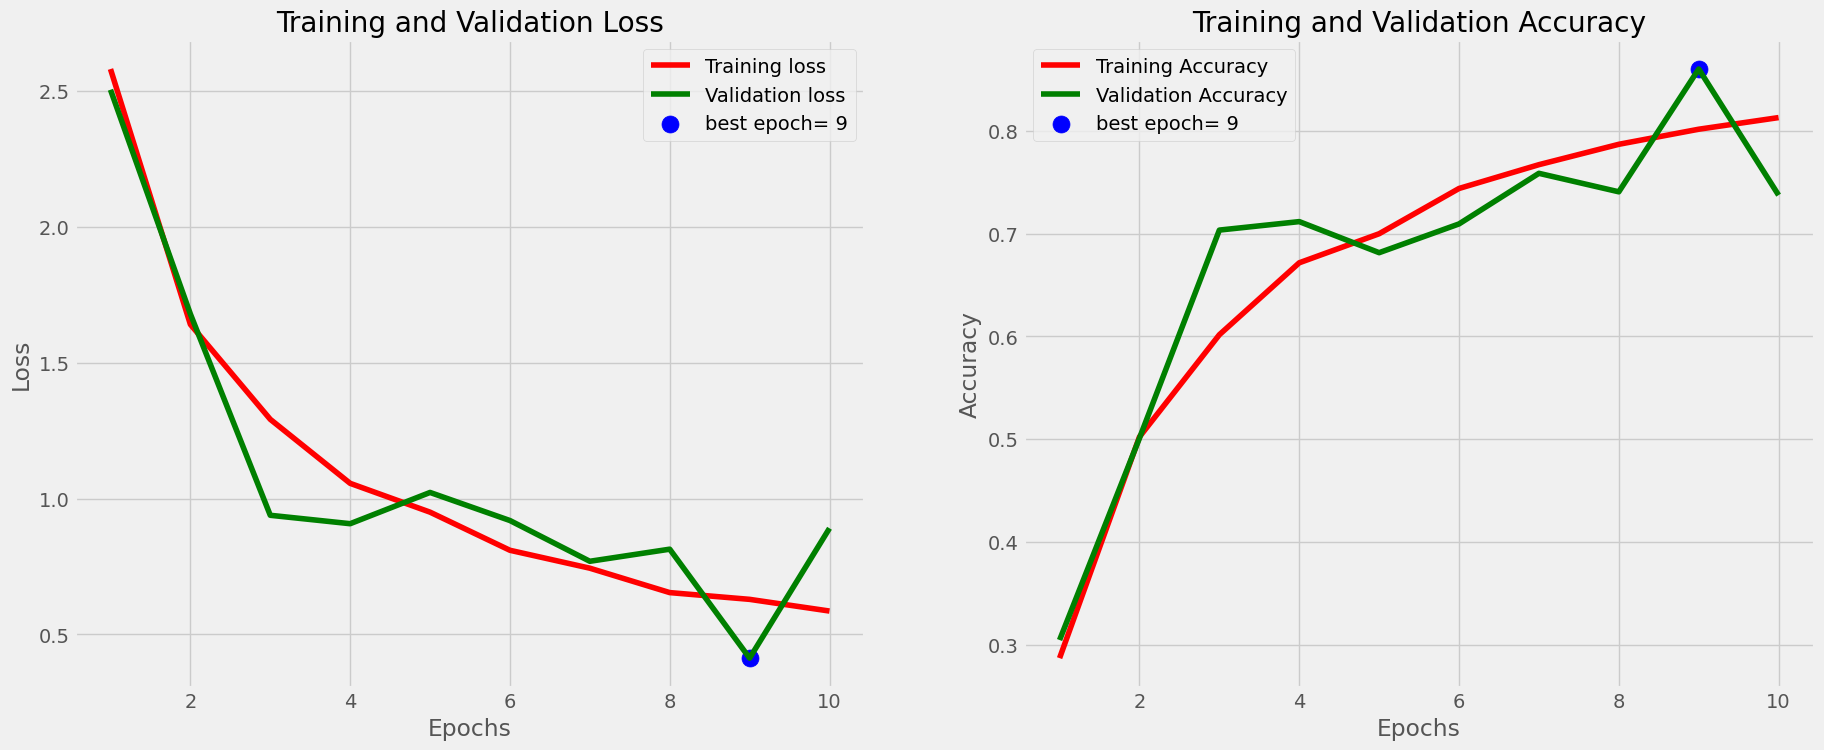

In [75]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(fitted_model,0)

## Basic Model Evaluation

In [76]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 63, 63, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                      

In [77]:
#Label assignment
label=['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy',
       'Blueberry___healthy','Cherry_(including_sour)___healthy','Cherry_(including_sour)___Powdery_mildew',
       'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Corn_(maize)___Common_rust_',
       'Corn_(maize)___healthy','Corn_(maize)___Northern_Leaf_Blight','Grape___Black_rot','Grape___Esca_(Black_Measles)',
       'Grape___healthy','Grape___Leaf_blight_(Isariopsis_Leaf_Spot)','Orange___Haunglongbing_(Citrus_greening)','Peach___Bacterial_spot',
       'Peach___healthy','Pepper,_bell___Bacterial_spot','Pepper,_bell___healthy','Potato___Early_blight',
       'Potato___healthy','Potato___Late_blight','Raspberry___healthy','Soybean___healthy',
       'Squash___Powdery_mildew','Strawberry___healthy','Strawberry___Leaf_scorch','Tomato___Bacterial_spot',
       'Tomato___Early_blight','Tomato___healthy','Tomato___Late_blight','Tomato___Leaf_Mold',
       'Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted_spider_mite','Tomato___Target_Spot',
       'Tomato___Tomato_mosaic_virus','Tomato___Tomato_Yellow_Leaf_Curl_Virus']

## Output Prediction

In [101]:
def testing(path):
    test_image = load_img(path, target_size=(128, 128))
    test_image = img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    result = model.predict(test_image)

    fresult = np.max(result)
    label2 = label[result.argmax()]
    print(f"Your leaf disease is --> {label2}")

#Calling Testing()
path = '/Users/kaustavghoshdastidar/Documents/My_World/My_Study_Program/Masters/Research_Paper-Assignments/ADS-599_Final_Capstone_Project/plant_leaf_diesease_detection/images_for_test/CornCommonRust2.JPG'
#path = 'images_for_test/CornCommonRust2.JPG'
testing(path)


1/1 [==============================] - 0s 15ms/step
Your leaf disease is --> Corn_(maize)___Common_rust_


In [87]:
# Load pre-trained ResNet50 model without the top layer to use as a base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

num_classes = 38
# Freeze the base model
base_model.trainable = False

In [88]:

# Create a new model with ResNet as the base
model_resnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Replace 'num_classes' with the actual number of classes
])

# Compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [90]:
# Print model summary to verify the architecture
model_resnet.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_8   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_23 (Dense)            (None, 128)               262272    
                                                                 
 dense_24 (Dense)            (None, 38)                4902      
                                                                 
Total params: 23,854,886
Trainable params: 267,174
Non-trainable params: 23,587,712
_________________________________________________________________


In [91]:
# Prepare data generators (assuming train_dir and valid_dir are defined)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Set up the training and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


### ResNet MODEL Trainining

In [93]:
# Train the model
fitted_model_resnet = model_resnet.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=valid_generator,
    validation_steps=len(valid_generator)
)

Epoch 1/10
2197/2197 [==============================] - 981s 446ms/step - loss: 3.3255 - accuracy: 0.1072 - val_loss: 3.0419 - val_accuracy: 0.1515
Epoch 2/10
2197/2197 [==============================] - 1135s 516ms/step - loss: 2.8591 - accuracy: 0.2195 - val_loss: 2.6165 - val_accuracy: 0.2840
Epoch 3/10
2197/2197 [==============================] - 1153s 525ms/step - loss: 2.5712 - accuracy: 0.2825 - val_loss: 2.4290 - val_accuracy: 0.3158
Epoch 4/10
2197/2197 [==============================] - 1229s 560ms/step - loss: 2.4036 - accuracy: 0.3173 - val_loss: 2.3249 - val_accuracy: 0.3294
Epoch 5/10
2197/2197 [==============================] - 1200s 546ms/step - loss: 2.2983 - accuracy: 0.3416 - val_loss: 2.2939 - val_accuracy: 0.3378
Epoch 6/10
2197/2197 [==============================] - 5321s 2s/step - loss: 2.2080 - accuracy: 0.3610 - val_loss: 2.2320 - val_accuracy: 0.3514
Epoch 7/10
2197/2197 [==============================] - 2293s 1s/step - loss: 2.1527 - accuracy: 0.3752 - val_

### Plotting Training and Validation Data For ResNet Model

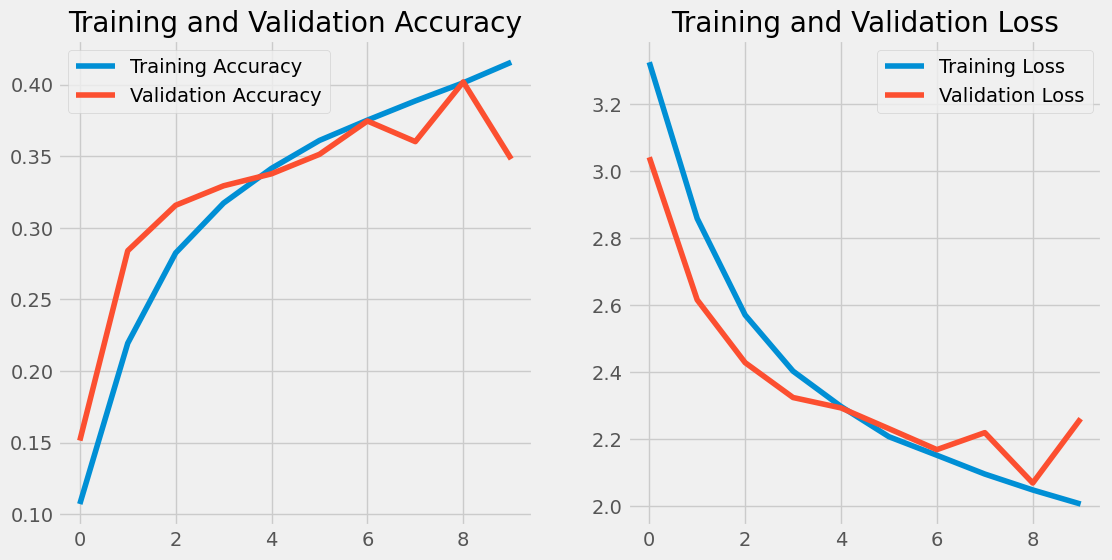

In [96]:
# Plot training and validation accuracy/loss
#import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training_history(fitted_model_resnet)

## ResNet Model Evaluation

In [98]:
model_resnet.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_8   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_23 (Dense)            (None, 128)               262272    
                                                                 
 dense_24 (Dense)            (None, 38)                4902      
                                                                 
Total params: 23,854,886
Trainable params: 267,174
Non-trainable params: 23,587,712
_________________________________________________________________


## Observation

The **ResNet model** outperformed the **basic CNN** due to its advanced architecture, which captures complex features necessary for identifying fine-grained leaf disease patterns. 

While the basic CNN serves as a good baseline, ResNet's improved validation performance makes it a more robust choice for deployment in practical applications, especially where accuracy is critical. 